In [117]:
from configs.RecursiveVPSDE.recursive_LearnSampleScore_fOU_T256_H07_tl_5data import get_config
#from configs.RecursiveVPSDE.recursive_fOU_T256_H07_tl_5data import get_config
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalLSTMTSSampleScoreMatching import \
    ConditionalLSTMTSSampleScoreMatching
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalLSTMTSScoreMatching import \
    ConditionalLSTMTSScoreMatching
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion

In [118]:
config = get_config()
assert (0 < config.hurst < 1.)
assert (config.early_stop_idx == 0)
assert (config.tdata_mult == 5)
print(config.scoreNet_trained_path, config.dataSize)
rng = np.random.default_rng()
scoreModel = ConditionalLSTMTSSampleScoreMatching(
    *config.model_parameters) if config.model_choice == "TSM"else None
train_epoch = 1920
scoreModel.load_state_dict(torch.load(config.scoreNet_trained_path + "_NEp" + str(train_epoch)))
N = 1000
data_shape = (N, 1, 1)
device = "cpu"
diff_time_scale = torch.linspace(start=config.end_diff_time, end=config.sample_eps,
                                   steps=config.max_diff_steps)
diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)
ts_step = 1/config.ts_length

/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_LSS_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5 40000


In [119]:
# real time 0
prev_path = torch.zeros((data_shape[0], 1, data_shape[-1])).to(device)#torch.normal(mean=0, std=np.sqrt(1/config.ts_length), size=(data_shape[0], 1, data_shape[-1])).to(device)
feature, (h, c) = scoreModel.rnn(prev_path, None) # Feature for real time 0
tau = diff_time_scale[900] * torch.ones((data_shape[0],)).to(device) # End of reverse-diffusion

In [120]:
# Create a linear sequence of "corrupted samples"
diffusion_mean2 = torch.atleast_2d(torch.exp(-diffusion.get_eff_times(diff_times=tau))).T.to(device)
diffusion_var = 1. - diffusion_mean2
exp_mean = torch.sqrt(diffusion_mean2)*(ts_step)*(-0.8*prev_path.squeeze(-1))
assert(exp_mean.shape == prev_path.squeeze(-1).shape)
exp_var = diffusion_var+diffusion_mean2*(ts_step)
Xtaus = torch.sort(torch.normal(mean=exp_mean, std=torch.sqrt(exp_var)).reshape((N, data_shape[1],1)), dim=0)[0]

0.949833 tensor([[0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
 

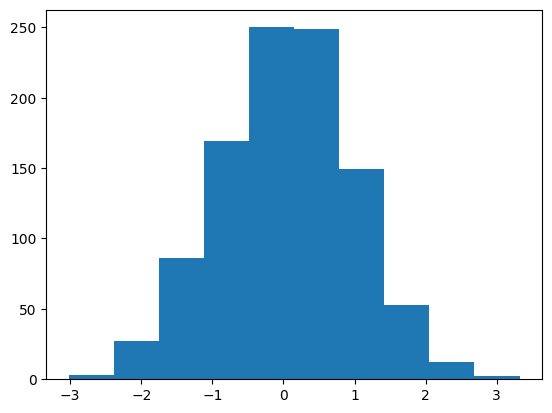

In [121]:
plt.hist(Xtaus.squeeze())
print(np.std(Xtaus.squeeze().numpy()),torch.sqrt(exp_var))

In [122]:
with torch.no_grad():
    try:
        score_evals = scoreModel.forward(inputs=Xtaus, times=tau, conditioner=feature, eff_times=diffusion.get_eff_times(tau.reshape(Xtaus.shape)))
    except TypeError:
        score_evals = scoreModel.forward(inputs=Xtaus, times=tau, conditioner=feature)
score_evals.shape

torch.Size([1000, 1, 1])

<>:2: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:2: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_25845/2980509627.py:2: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(Xtaus.shape == (data_shape[0],1,1), score_evals.shape==(data_shape[0],1,1))


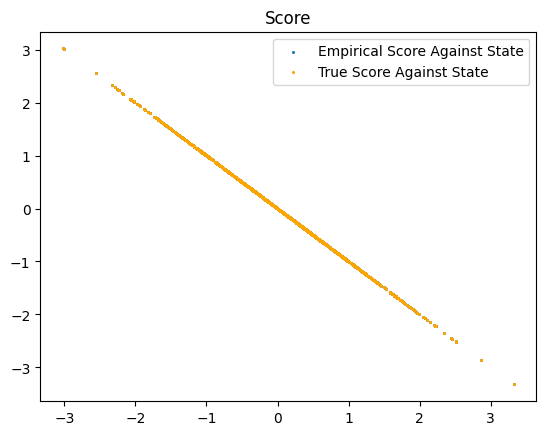

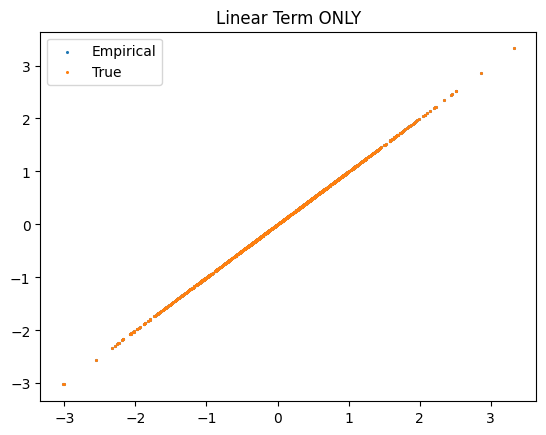

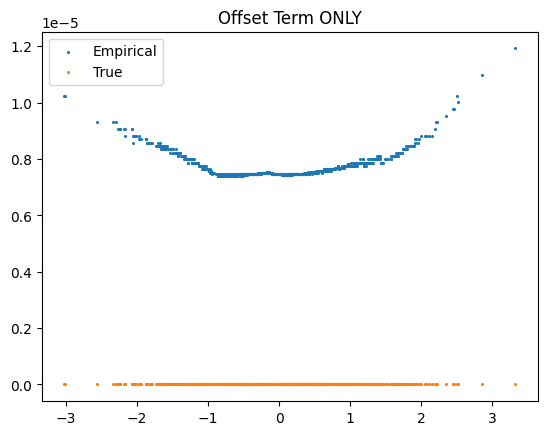

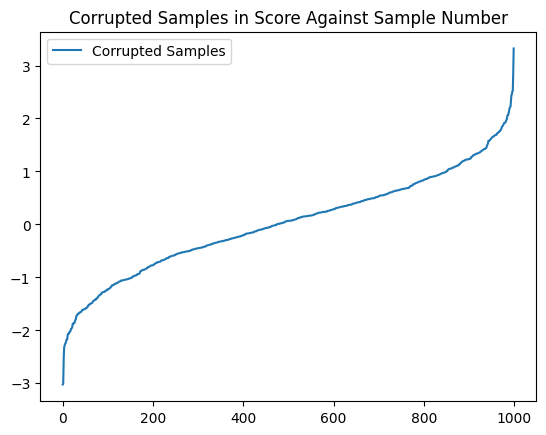

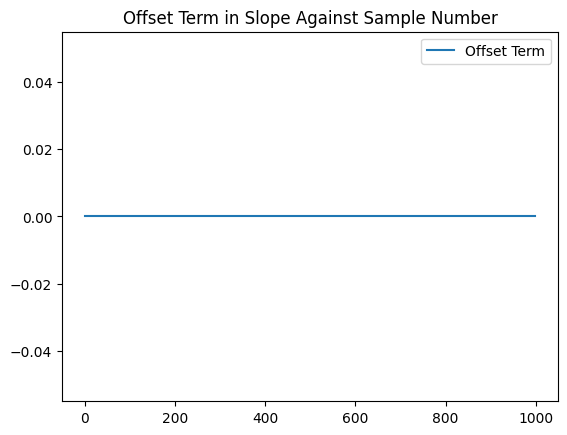

In [138]:
def check_linear_score(config,Xtaus, score_evals, diffusion_var, diffusion_mean2, ts_step, prev_path):
    assert(Xtaus.shape == (data_shape[0],1,1), score_evals.shape==(data_shape[0],1,1))
    Xts = Xtaus.squeeze()
    scores = score_evals.squeeze()
    paired = zip(Xts.numpy(), scores.numpy())
    # Sort the pairs based on values of arr1
    sorted_pairs = sorted(paired, key=lambda x: x[0])
    # Separate the pairs back into two arrays
    Xts, scores = zip(*sorted_pairs)
    Xts = np.array(Xts)
    scores = np.array(scores)
    plt.scatter(Xts, scores, label="Empirical Score Against State", s=1.5)
    exp_slope = -(1/((diffusion_var + diffusion_mean2 * ts_step))[0]).numpy()[0]
    exp_const = (torch.sqrt(diffusion_mean2)*(ts_step)*(-config.mean_rev*prev_path.squeeze(-1))).numpy()[0]
    plt.scatter(Xts, exp_slope*(Xts-exp_const), color="orange", label="True Score Against State", s=1.5)
    plt.title("Score")
    plt.legend()
    plt.show()
    plt.close()
    plt.scatter(Xts,scores/exp_slope, label="Empirical", s=1.5)
    plt.scatter(Xts,Xts-exp_const, label="True", s=1.5)
    plt.title("Linear Term ONLY")
    plt.legend()
    plt.show()
    plt.close()
    plt.scatter(Xts,-Xts+scores/exp_slope, label="Empirical", s=1.5)
    plt.scatter(Xts,-exp_const*np.ones_like(Xts), label="True", s=1.5)
    plt.title("Offset Term ONLY")
    plt.legend()
    plt.show()
    plt.close()
    plt.plot(Xts, label="Corrupted Samples")
    plt.title("Corrupted Samples in Score Against Sample Number")
    plt.legend()
    plt.show()
    plt.close()
    plt.plot(exp_const*np.ones_like(Xts), label="Offset Term")
    plt.title("Offset Term in Slope Against Sample Number")
    plt.legend()
    plt.show()
    plt.close()
check_linear_score(config=config,Xtaus=Xtaus, score_evals=score_evals, diffusion_var=diffusion_var,diffusion_mean2=diffusion_mean2,ts_step=ts_step, prev_path=prev_path)

torch.Size([1000]) torch.Size([]) torch.Size([1000]) torch.Size([1000])


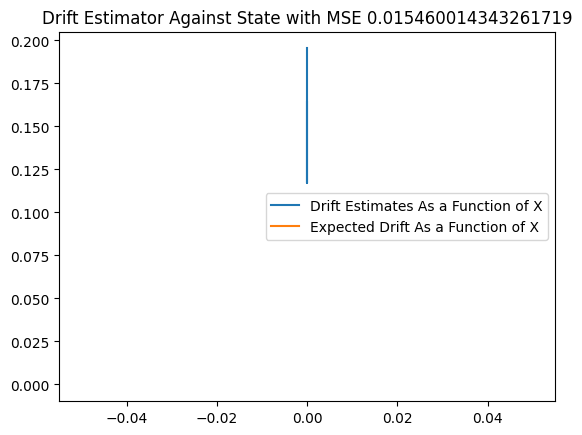

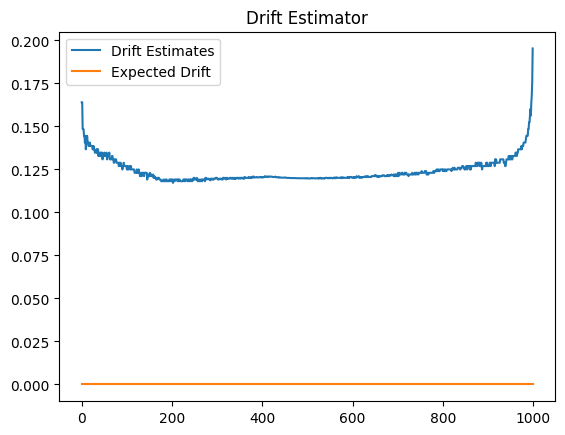

tensor([-0.1641, -0.1641, -0.1484, -0.1484, -0.1484, -0.1445, -0.1445, -0.1406,
        -0.1445, -0.1367, -0.1406, -0.1445, -0.1445, -0.1406, -0.1406, -0.1387,
        -0.1387, -0.1387, -0.1406, -0.1387, -0.1387, -0.1387, -0.1387, -0.1387,
        -0.1367, -0.1367, -0.1387, -0.1367, -0.1367, -0.1348, -0.1348, -0.1348,
        -0.1348, -0.1367, -0.1348, -0.1367, -0.1367, -0.1328, -0.1348, -0.1328,
        -0.1328, -0.1348, -0.1328, -0.1348, -0.1348, -0.1348, -0.1309, -0.1328,
        -0.1328, -0.1328, -0.1348, -0.1328, -0.1328, -0.1328, -0.1328, -0.1348,
        -0.1309, -0.1328, -0.1328, -0.1328, -0.1328, -0.1348, -0.1309, -0.1309,
        -0.1309, -0.1309, -0.1309, -0.1328, -0.1328, -0.1309, -0.1309, -0.1289,
        -0.1289, -0.1309, -0.1309, -0.1309, -0.1309, -0.1289, -0.1289, -0.1289,
        -0.1289, -0.1289, -0.1270, -0.1270, -0.1289, -0.1270, -0.1289, -0.1270,
        -0.1270, -0.1270, -0.1250, -0.1270, -0.1270, -0.1289, -0.1270, -0.1270,
        -0.1270, -0.1270, -0.1270, -0.12

In [139]:
# Build drift estimator
def build_drift_estimator(config,diffusion_var, diffusion_mean2, ts_step, score_evals, Xtaus, prev_path):
    try:
        assert(len(diffusion_var.shape) == len(diffusion_mean2.shape) == len(score_evals.shape)==len(Xtaus.shape)==len(prev_path.shape))
    except AssertionError:
        diffusion_var = diffusion_var.squeeze()
        diffusion_mean2 = diffusion_mean2.squeeze()
        score_evals = score_evals.squeeze()
        Xtaus = Xtaus.squeeze()
        prev_path = prev_path.squeeze()
        assert(type(ts_step)==float)
    c1 = ((diffusion_var + diffusion_mean2 * ts_step) / (torch.pow(diffusion_mean2, 0.5))[0])
    c2 = (torch.pow(diffusion_mean2, -0.5))[0]
    print(c1.shape, c2.shape, score_evals.shape, Xtaus.shape)
    mean_est = c1 * score_evals + c2 * Xtaus
    mean_est /= ts_step
    assert(prev_path.shape == mean_est.shape)
    plt.plot(prev_path,-mean_est, label="Drift Estimates As a Function of X")
    plt.plot(prev_path,-config.mean_rev*prev_path, label="Expected Drift As a Function of X")
    plt.title(f"Drift Estimator Against State with MSE {torch.mean(torch.pow(mean_est--config.mean_rev*prev_path.squeeze(), 2))}")
    plt.legend()
    plt.plot()
    plt.show()
    plt.close()
    plt.plot(-mean_est, label="Drift Estimates")
    plt.plot(-config.mean_rev*prev_path, label="Expected Drift")
    plt.title("Drift Estimator")
    plt.legend()
    plt.plot()
    plt.show()
    plt.close()
    return mean_est
build_drift_estimator(config=config,diffusion_var=diffusion_var, diffusion_mean2=diffusion_mean2, ts_step=ts_step, score_evals=score_evals, Xtaus=Xtaus, prev_path=prev_path)

In [140]:
def single_time_sampling(config, diff_time_space, diffusion, feature, scoreModel, device, prev_path, param_est_time):
    x = diffusion.prior_sampling(shape=data_shape).to(device)  # Move to correct device
    scores = []
    exp_scores = []
    for diff_index in tqdm(range(config.max_diff_steps)):
        tau = diff_time_space[diff_index]*torch.ones((data_shape[0],)).to(device)
        try:
            score, drift, diffParam = diffusion.get_conditional_reverse_diffusion(x=x, t=tau,
                                                                                      feature=feature,
                                                                                      score_network=scoreModel,
                                                                                      diff_index=torch.Tensor([int(diff_index)]).to(device),
                                                                                      max_diff_steps=config.max_diff_steps)
        except TypeError as e:
            score, drift, diffParam = diffusion.get_conditional_learnsample_reverse_diffusion(x=x, t=tau,
                                                                                      feature=feature,
                                                                                      score_network=scoreModel,
                                                                                      diff_index=torch.Tensor([int(diff_index)]).to(device),
                                                                                      max_diff_steps=config.max_diff_steps)
        if len(score.shape) == 3 and score.shape[-1] == 1:
            score = score.squeeze(-1)
        scores.append(score)
        diffusion_mean2 = torch.atleast_2d(torch.exp(-diffusion.get_eff_times(diff_times=tau))).T.to(device)
        diffusion_var = 1. - diffusion_mean2
        exp_slope = -(1/((diffusion_var + diffusion_mean2 * ts_step))[0])
        exp_const = torch.sqrt(diffusion_mean2)*(ts_step)*(-config.mean_rev*prev_path.squeeze(-1))
        exp_score = exp_slope*(x.squeeze(-1)-exp_const)
        if len(exp_score) ==3 and exp_score.shape[0]==1:
            exp_score = exp_score.squeeze(-1)
        exp_scores.append(exp_score)
        if diff_index == param_est_time:
            print(f"Param Estimation at Diff Time {param_est_time} with BetaTau2 {(diffusion_mean2[0].squeeze())} and SigmaTau {(diffusion_var[0].squeeze())}")
            check_linear_score(config=config,Xtaus=x, score_evals=score, diffusion_var=diffusion_var, diffusion_mean2=diffusion_mean2, ts_step=ts_step, prev_path=prev_path)
            mean_est = build_drift_estimator(config=config,diffusion_var=diffusion_var, diffusion_mean2=diffusion_mean2, ts_step=ts_step, score_evals=score, Xtaus=x, prev_path=prev_path)
        z = torch.randn_like(drift)
        x = drift + diffParam * z
    return x, mean_est, torch.flip(torch.concat(scores,dim=-1),dims=[1]), torch.flip(torch.concat(exp_scores, dim=-1), dims=[1])

In [141]:
def evaluate_ts_marginal_histogram(samples, ts_time, config, train_epoch):
    expmeanrev = np.exp(-config.mean_rev * ts_time)
    exp_mean = config.mean * (1. - expmeanrev)
    exp_mean += config.initState * expmeanrev
    exp_var = np.power(config.diffusion, 2)
    exp_var /= (2 * config.mean_rev)
    exp_var *= 1. - np.power(expmeanrev, 2)
    exp_rvs = np.random.normal(loc=exp_mean, scale=np.sqrt(exp_var), size=samples.shape[0])
    plt.hist(samples.squeeze(), bins=150, density=True, label="True")
    plt.hist(exp_rvs, bins=150, density=True, label="Expected")
    plt.title(f"Marginal Distributions at time {ts_time} for epoch {train_epoch}")
    plt.legend()
    plt.show()
    plt.close()
def evaluate_scores(scores, exp_scores, diff_time_scale):
    assert(scores.shape == exp_scores.shape)
    plt.plot(diff_time_scale, scores.mean(dim=0).squeeze())
    plt.title("Sample-Averaged Empirical scores")
    plt.show()
    plt.close()
    plt.plot(diff_time_scale, exp_scores.mean(dim=0).squeeze())
    plt.title("Sample-Averaged True scores")
    plt.show()
    plt.close()
    errs = torch.linalg.norm((scores-exp_scores).squeeze(), ord=2).mean(dim=0)
    plt.plot(diff_time_scale, errs.squeeze())
    plt.title("MSE Of Scores")
    plt.show()
    plt.close()
def evaluate_per_time_samples(samples, scores,exp_scores,ts_time, train_epoch,diff_time_scale, config):
    try:
        assert(samples.shape == (data_shape[0],1))
    except AssertionError:
        samples = samples.squeeze(-1)
    evaluate_ts_marginal_histogram(samples=samples, ts_time=ts_time, train_epoch=train_epoch,config=config)
    evaluate_scores(scores=scores, exp_scores=exp_scores, diff_time_scale=diff_time_scale)


In [142]:
def run_whole_ts_recursive_diffusion(config, initial_feature_input, diffusion, scoreModel, device, diff_time_scale, real_time_scale):
    samples = initial_feature_input
    param_est_time = 900
    for t in (range(config.ts_length)):
        print("Sampling at real time {}\n".format(t + 1))
        if t == 0:
            feature, (h, c) = scoreModel.rnn(samples, None)
        else:
            feature, (h, c) = scoreModel.rnn(samples, (h, c))
        new_samples, mean, scores, exp_scores = single_time_sampling(config=config,diff_time_space=diff_time_scale, diffusion=diffusion, scoreModel=scoreModel, device=device, feature=feature, prev_path=samples, param_est_time=param_est_time)
        cumsumsamples = new_samples + samples # For evaluation, we need PATH VALUE, not increment
        samples = new_samples # But we feed latest INCREMENT to the LSTM
        evaluate_per_time_samples(samples=cumsumsamples, scores=scores, exp_scores=exp_scores,ts_time=real_time_scale[t], train_epoch=train_epoch, diff_time_scale=diff_time_scale, config=config)

Sampling at real time 1



  9%|▉         | 897/10000 [00:22<04:24, 34.42it/s]

Param Estimation at Diff Time 900 with BetaTau2 0.0002532711951062083 and SigmaTau 0.9997467398643494


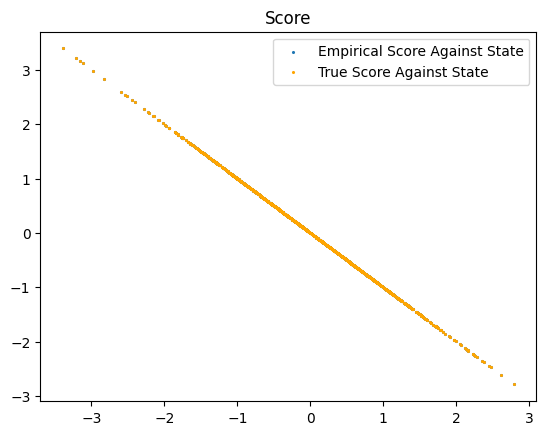

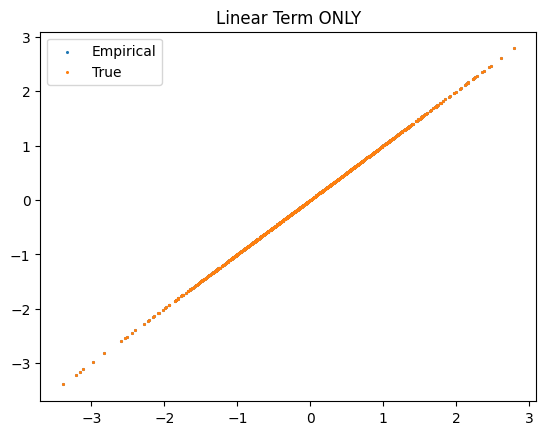

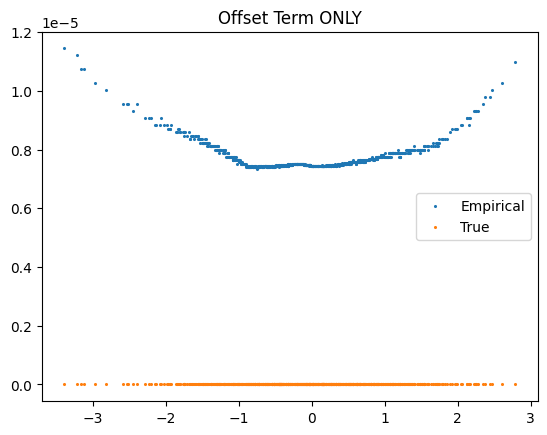

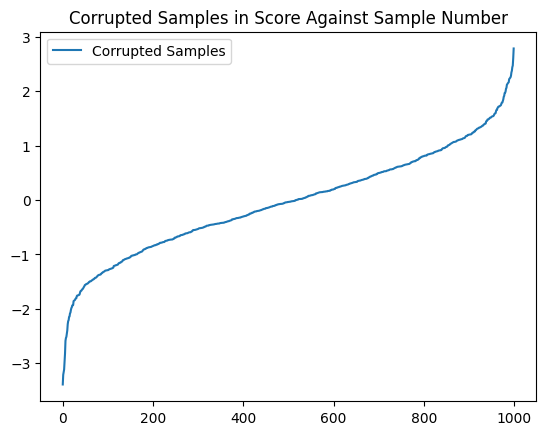

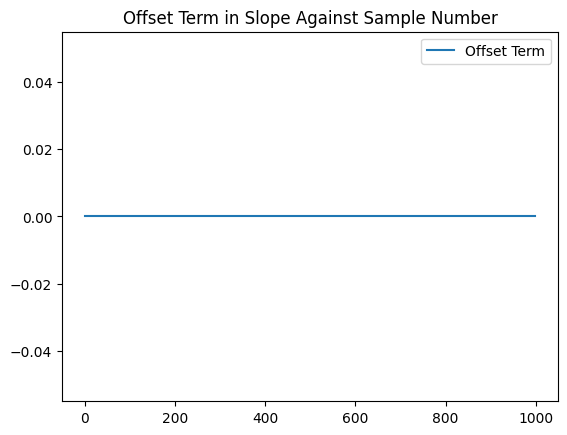

torch.Size([1000]) torch.Size([]) torch.Size([1000]) torch.Size([1000])


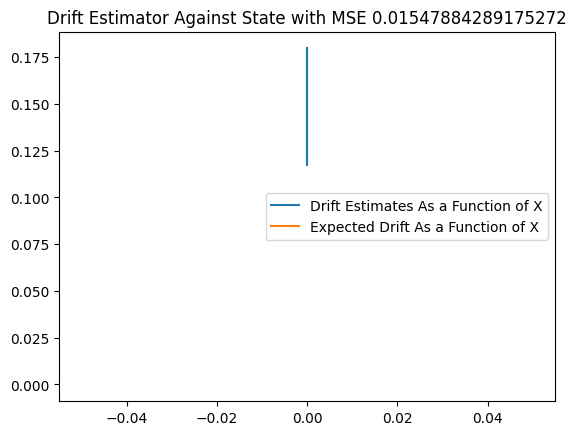

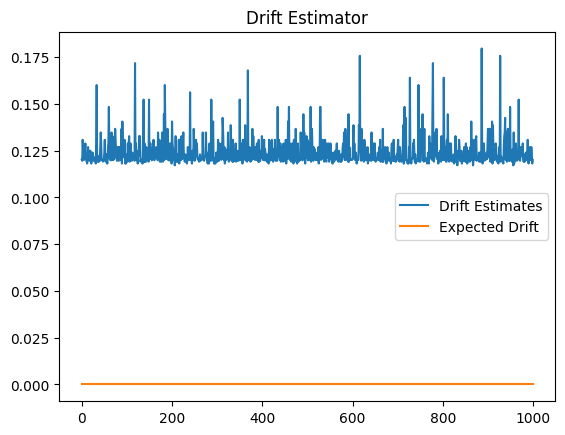

100%|██████████| 10000/10000 [04:30<00:00, 36.90it/s]


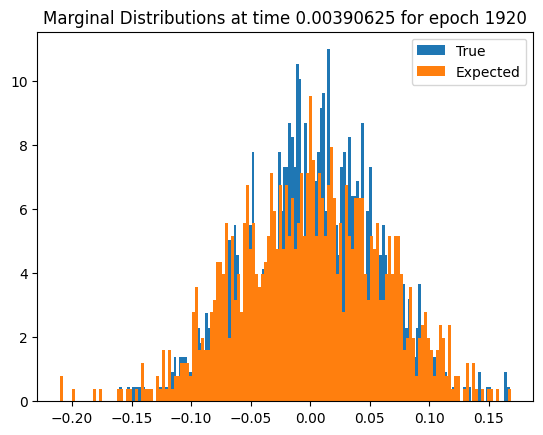

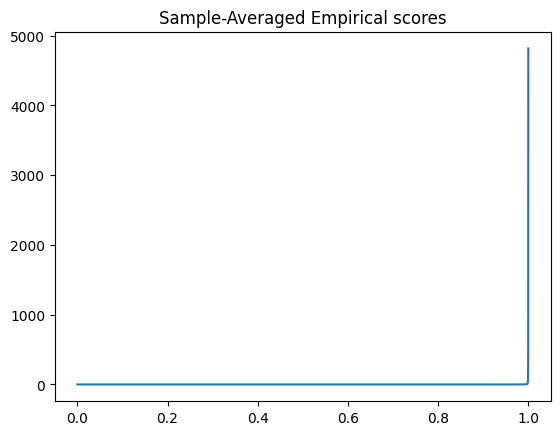

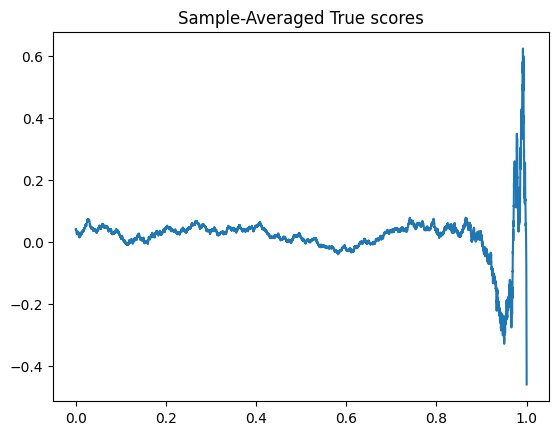

ValueError: x and y must have same first dimension, but have shapes torch.Size([10000]) and (1,)

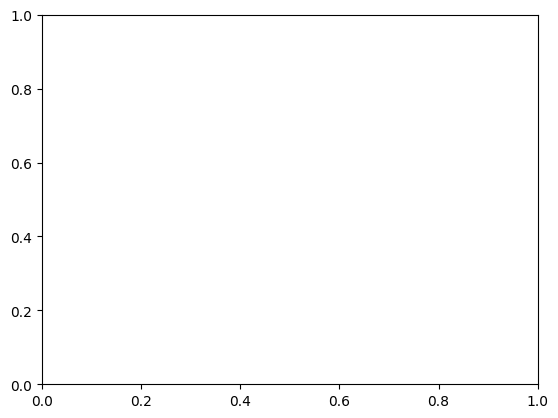

In [143]:
initial_feature_input = torch.zeros(data_shape).to(device)
diff_time_scale = torch.linspace(start=config.end_diff_time, end=config.sample_eps,
                                   steps=config.max_diff_steps)
real_time_scale = torch.linspace(start=1/config.ts_length, end=1,
                                   steps=config.ts_length)
run_whole_ts_recursive_diffusion(config=config, initial_feature_input=initial_feature_input, diffusion=diffusion, scoreModel=scoreModel, device=device, diff_time_scale=diff_time_scale, real_time_scale=real_time_scale)